# Google Play Store Applications Analysis
Source of the dataset: https://www.kaggle.com/datasets/bhavikjikadara/google-play-store-applications

## 1 Importing Libraries

In [1133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


## 2 Load the data

In [1134]:
df = pd.read_csv(
    'dataset.csv',
    thousands=',',
    index_col=0,
)

## 3 Data Preprocessing
This may involve handling missing values, converting data types, or normalising
the data
### 3.1 Understanding the Data 

In [1135]:
df.shape

(10841, 13)

In [1136]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [1137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.2+ MB


In [1138]:
df.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


### 3.2 Data Cleaning -> Changing the data types to numeric or date values and handling missing values
#### 3.2.1 Changing 'Reviews' to numeric

In [1139]:
def convert_to_numeric(x):
    num = None
    if pd.isna(x):
        return x

    if ',' in x:
        x = x.replace(',', '')
    if '+' in x:
        x = x.replace('+', '')
    if '$' in x:
        x = x.replace('$', '')
    if "\"" in x:
        x = x.replace('\"', '')
    
    if 'M' in x:
        num =  float(x.replace('M', '')) * 10**6
    elif 'k' in x:
        num =  float(x.replace('k', '')) * 10**3
    elif '.' in x:
        num =  float(x)

    
    else:
        num =  float(x)

    return num

# Apply the function to the 'Reviews' column
df['Reviews'] = df['Reviews'].apply(convert_to_numeric)

df['Reviews'].describe()

count    1.084100e+04
mean     4.443887e+05
std      2.927728e+06
min      0.000000e+00
25%      3.800000e+01
50%      2.094000e+03
75%      5.479800e+04
max      7.815831e+07
Name: Reviews, dtype: float64

#### 3.2.2 Changing Size to numeric

In [1140]:
df.replace({'Size': 'Varies with device'}, pd.NA, inplace=True)
df['Size'] = df['Size'].apply(convert_to_numeric)
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')
df['Size'].describe()

count    9.146000e+03
mean     2.151418e+07
std      2.258863e+07
min      1.000000e+03
25%      4.900000e+06
50%      1.300000e+07
75%      3.000000e+07
max      1.000000e+08
Name: Size, dtype: float64

#### 3.2.3 Changing Installs to numeric

In [1141]:
df.replace({'Installs': ['+','Free']}, pd.NA, inplace=True)
df['Installs'] = df['Installs'].apply(convert_to_numeric)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
df['Installs'].describe()

count    1.084000e+04
mean     1.546434e+07
std      8.502936e+07
min      0.000000e+00
25%      1.000000e+03
50%      1.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

#### 3.2.4 Changing Price to numeric

In [1142]:
df.replace({'Price': 'Everyone'}, '0', inplace=True)
df['Price'] = df['Price'].apply(convert_to_numeric)
df['Price'].describe()

count    10841.000000
mean         1.027273
std         15.948971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        400.000000
Name: Price, dtype: float64

#### 3.2.5 Changing Last Updated to date

In [1143]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%d-%b-%y', errors="coerce")

### 3.3 Reviewing the data after cleaning

In [1144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             10841 non-null  object        
 1   Category        10841 non-null  object        
 2   Rating          9367 non-null   float64       
 3   Reviews         10841 non-null  float64       
 4   Size            9146 non-null   float64       
 5   Installs        10840 non-null  float64       
 6   Type            10840 non-null  object        
 7   Price           10841 non-null  float64       
 8   Content Rating  10840 non-null  object        
 9   Genres          10841 non-null  object        
 10  Last Updated    10840 non-null  datetime64[ns]
 11  Current Ver     10833 non-null  object        
 12  Android Ver     10838 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
memory usage: 1.2+ MB


In [1145]:
# For every column, get the value counts in descending order and take the index (value) of most common value
most_common = df.mode().iloc[0]
most_common

App                            ROBLOX
Category                       FAMILY
Rating                            4.4
Reviews                           0.0
Size                       11000000.0
Installs                    1000000.0
Type                             Free
Price                             0.0
Content Rating               Everyone
Genres                          Tools
Last Updated      2018-08-03 00:00:00
Current Ver        Varies with device
Android Ver                4.1 and up
Name: 0, dtype: object

## 4 Data Analysis

### 4.1 Descriptive Statistics


In [1146]:
# For every numeric column, print the mean, median, mode and standard deviation
for col in df.select_dtypes(include='number').columns:
    print(f"Column: {col}")
    print(f"Mean: {df[col].mean()}")
    print(f"Median: {df[col].median()}")
    print(f"Mode: {df[col].mode().iloc[0]}")
    print(f"Standard Deviation: {df[col].std()}")
    print()




Column: Rating
Mean: 4.193338315362443
Median: 4.3
Mode: 4.4
Standard Deviation: 0.5374313031477587

Column: Reviews
Mean: 444388.6535374965
Median: 2094.0
Mode: 0.0
Standard Deviation: 2927728.4640123826

Column: Size
Mean: 21514177.07194402
Median: 13000000.0
Mode: 11000000.0
Standard Deviation: 22588633.24344178

Column: Installs
Mean: 15464338.882564576
Median: 100000.0
Mode: 1000000.0
Standard Deviation: 85029361.39546256

Column: Price
Mean: 1.0272733142699015
Median: 0.0
Mode: 0.0
Standard Deviation: 15.948970817236914



In [1147]:
# For every column, if it is of data type object, print the value counts of the column
for col in df.select_dtypes(include='object').columns:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print()

Column: App
App
ROBLOX                                                9
CBS Sports App - Scores, News, Stats & Watch Live     8
ESPN                                                  7
Duolingo: Learn Languages Free                        7
Candy Crush Saga                                      7
                                                     ..
Meet U - Get Friends for Snapchat, Kik & Instagram    1
U-Report                                              1
U of I Community Credit Union                         1
Waiting For U Launcher Theme                          1
iHoroscope - 2018 Daily Horoscope & Astrology         1
Name: count, Length: 9660, dtype: int64

Column: Category
Category
FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE              

### 4.2 Data Visualisation

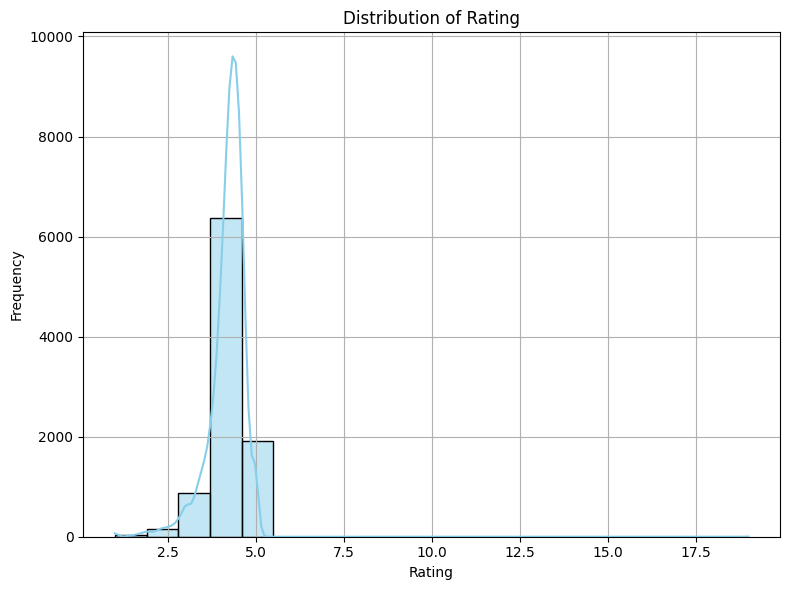

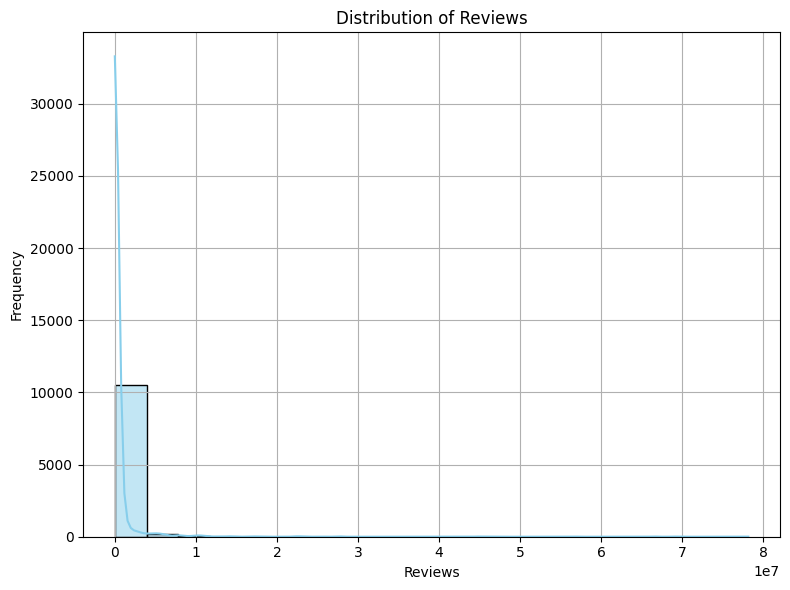

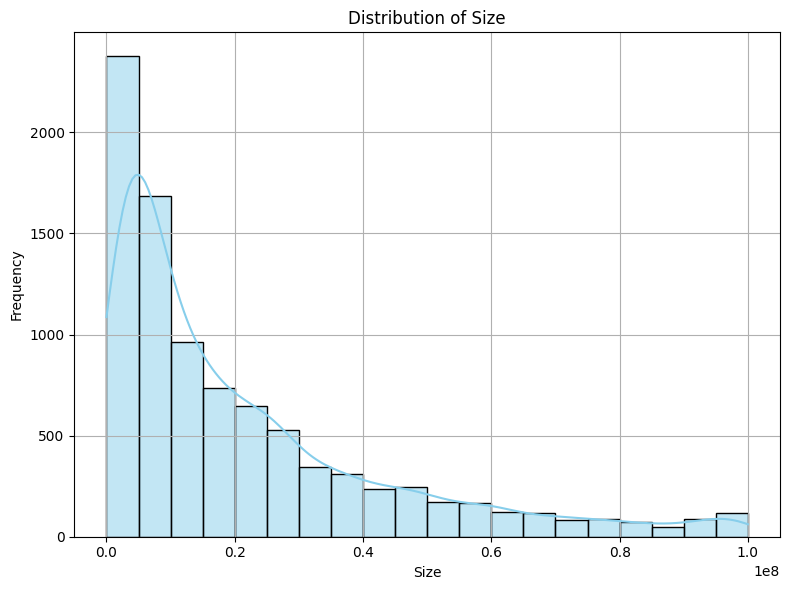

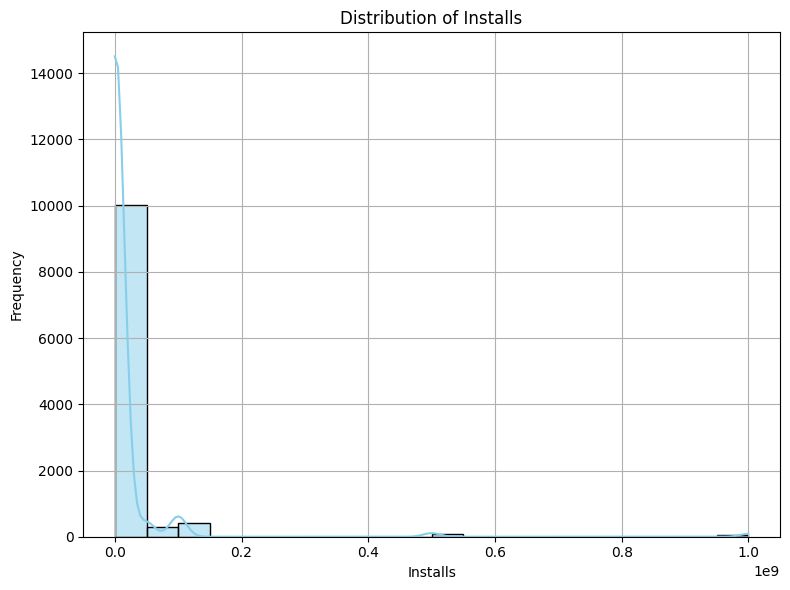

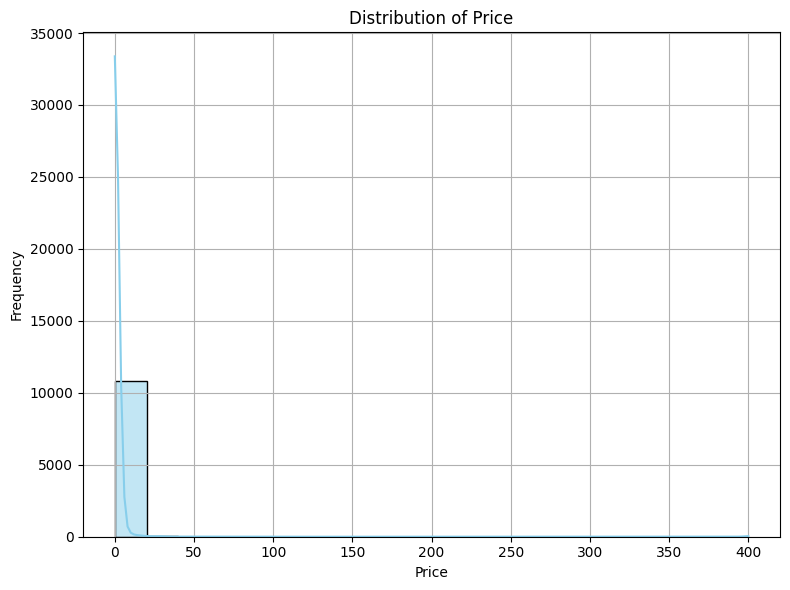

In [1148]:
# Histograms, Box Plots, and Scatter plots
# Adjust the appearance of numerical columns
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 6))  # Adjust the figure size
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')  # Adjust the number of bins and add kernel density estimation (kde)
    plt.xlabel(col.capitalize())  # Add x-axis label with capitalized column name
    plt.ylabel('Frequency')  # Add y-axis label
    plt.title(f'Distribution of {col.capitalize()}')  # Add a descriptive title
    plt.grid(True)  # Add gridlines
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()

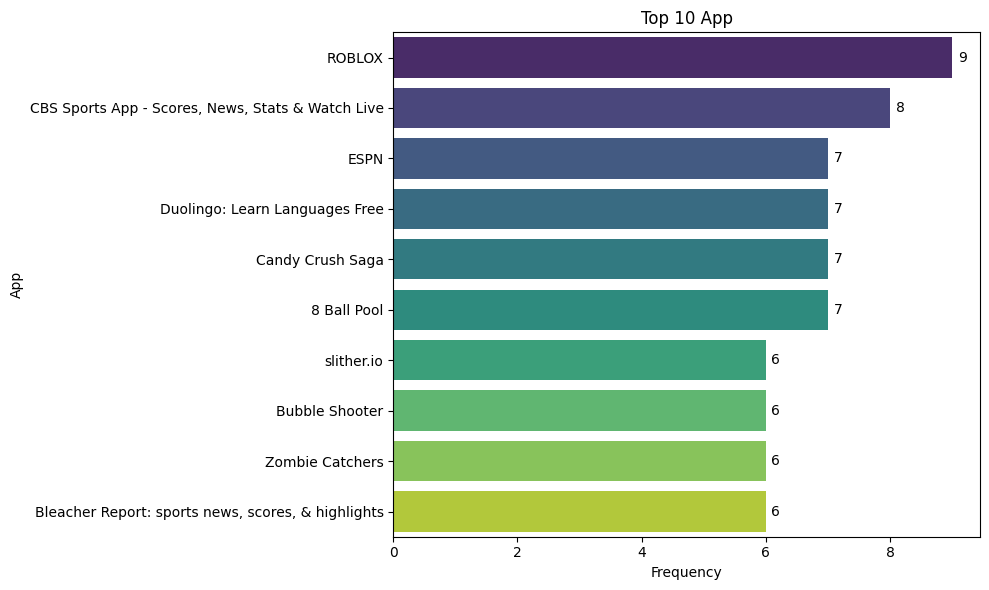

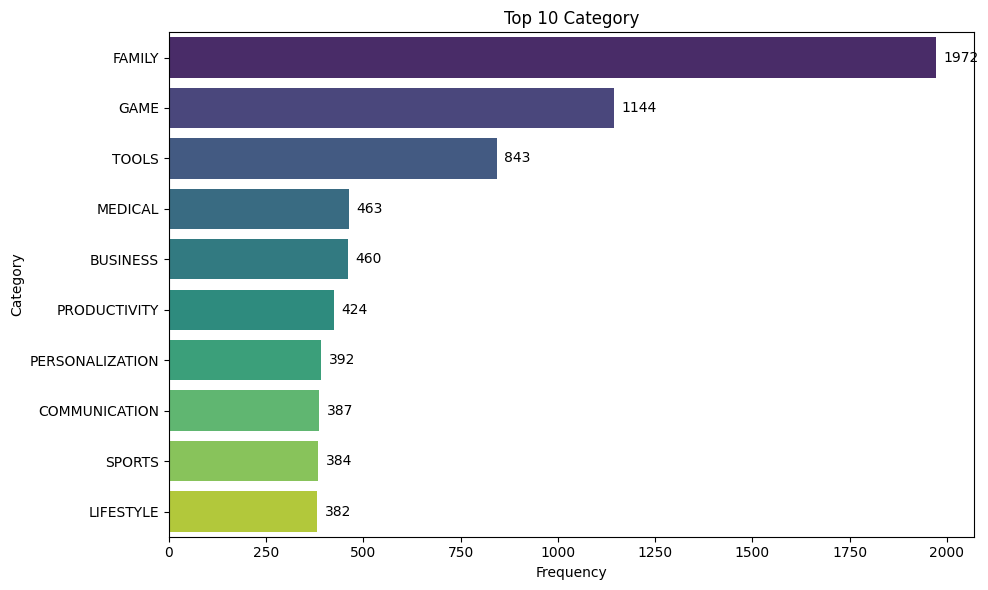

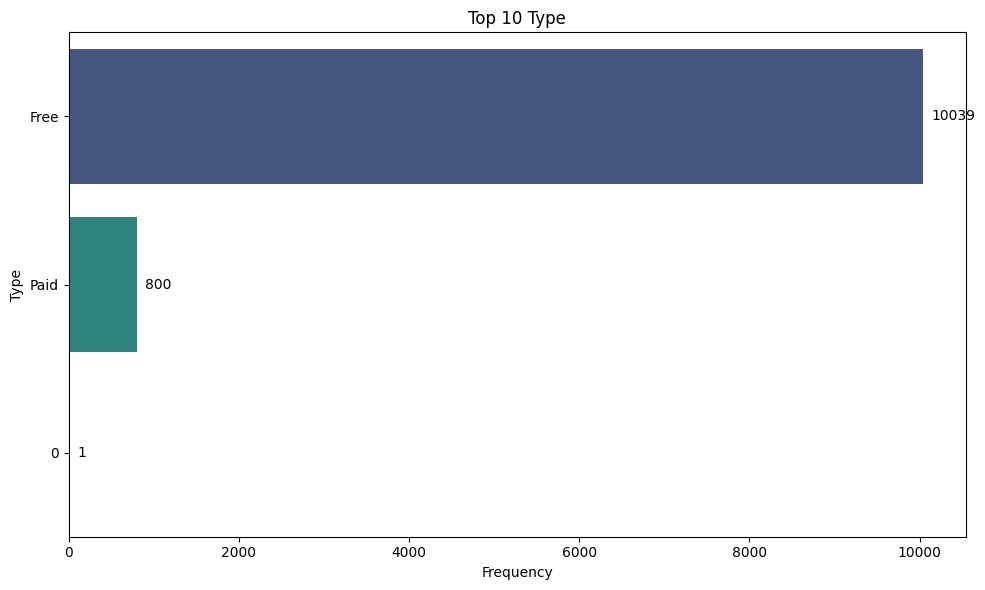

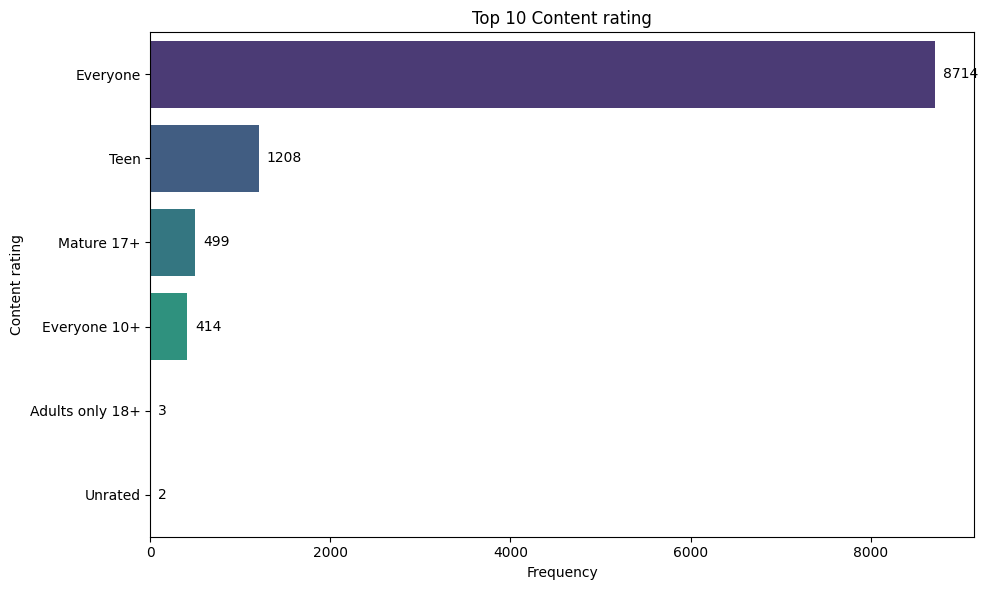

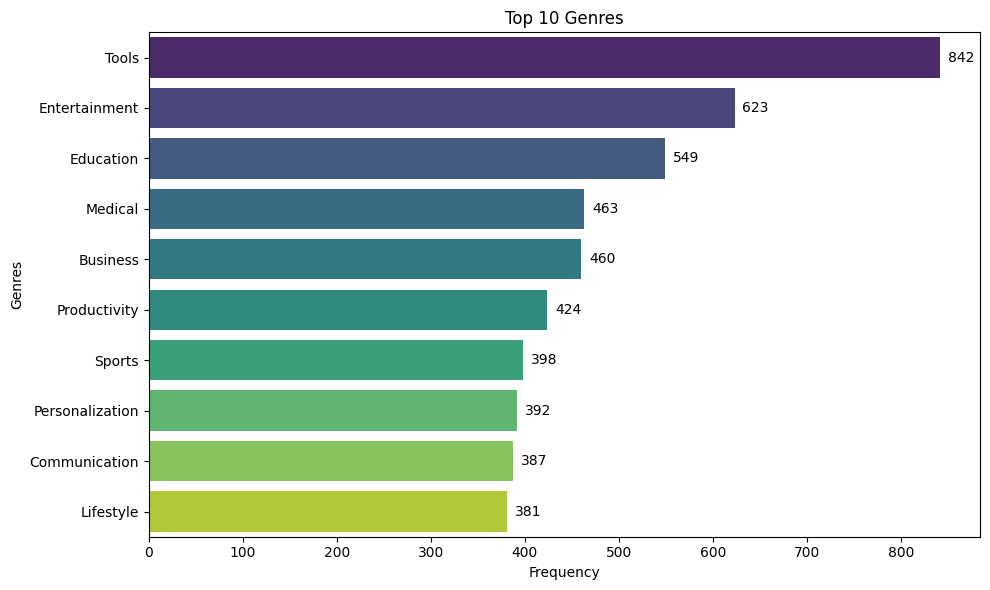

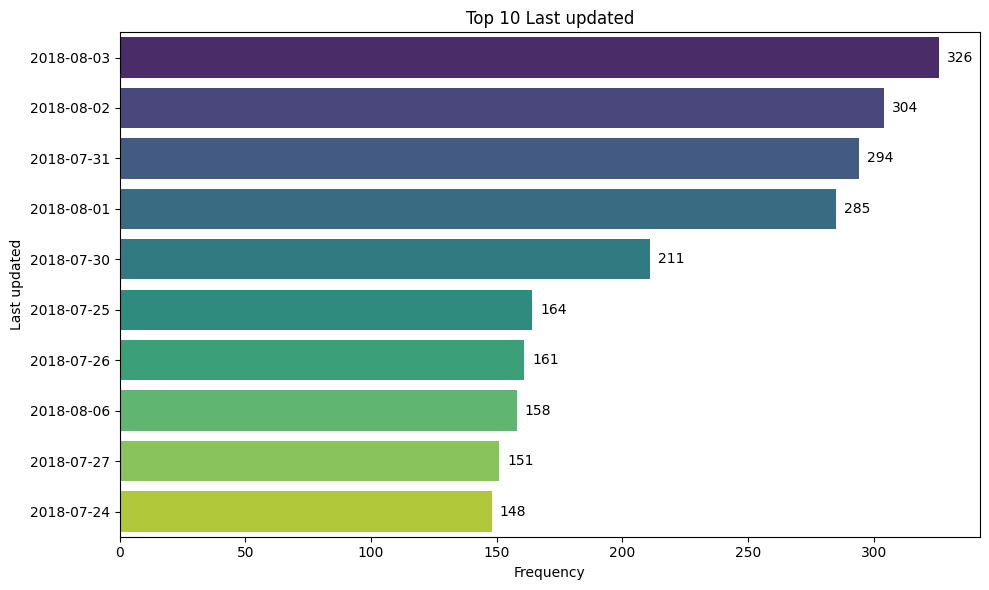

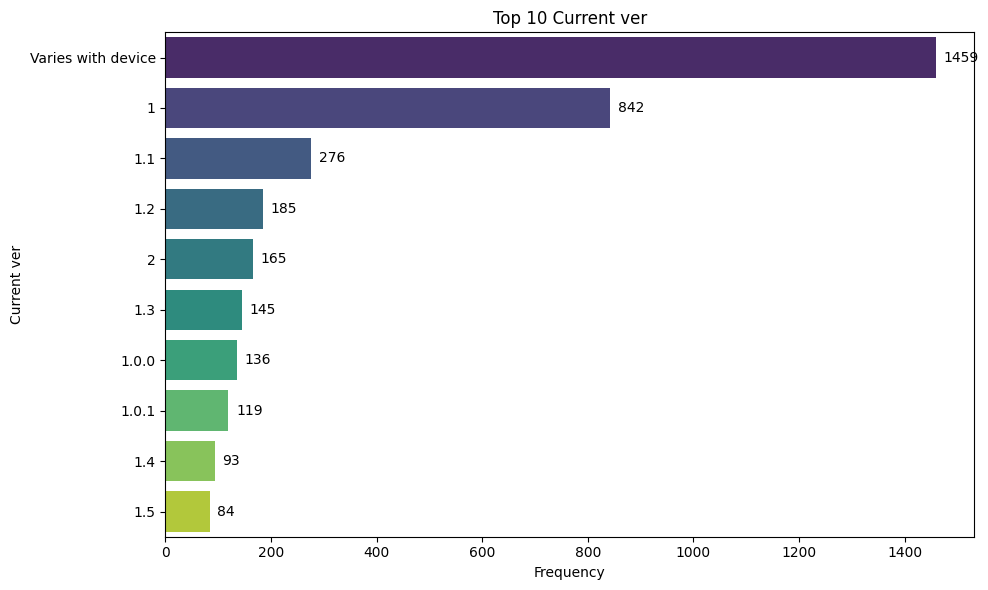

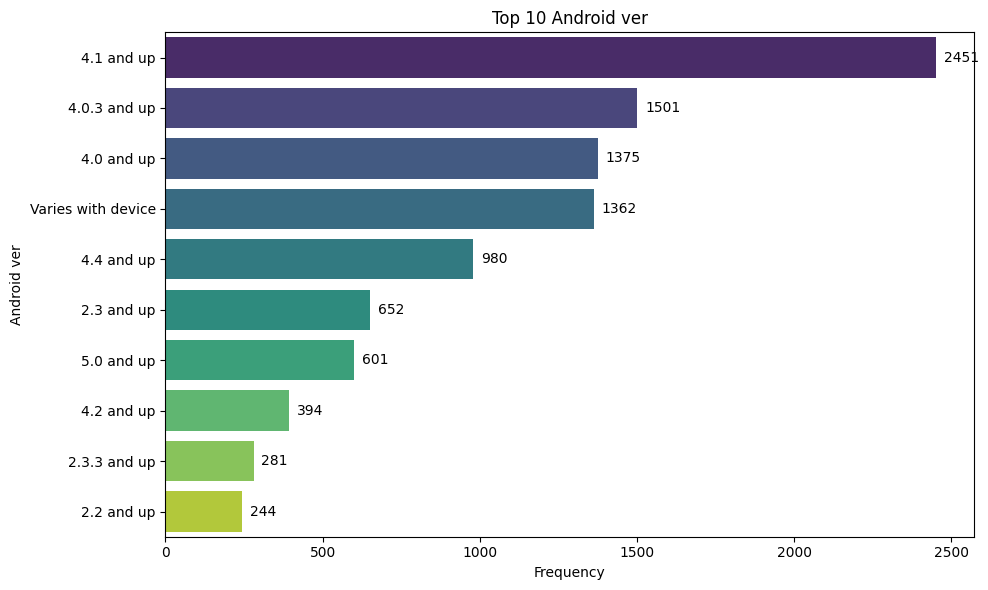

In [1149]:
non_numeric_columns = df.select_dtypes(exclude='number').columns

# Loop through non-numeric columns and create count plots for the top 10 most frequent values
for col in non_numeric_columns:
    top_10_values = df[col].value_counts().nlargest(10)  # Get the top 10 most frequent values
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    ax = sns.barplot(x=top_10_values.values, y=top_10_values.index, palette='viridis', ci=None)  # Create a bar plot with seaborn, ci=None to remove confidence intervals
    plt.xlabel('Frequency')  # Add x-axis label
    plt.ylabel(col.capitalize())  # Add y-axis label with capitalized column name
    plt.title(f'Top 10 {col.capitalize()}')  # Add a descriptive title

    # Annotate each bar with its value
    for i, v in enumerate(top_10_values.values):
        ax.text(v + max(top_10_values.values) * 0.01, i, str(v), color='black', va='center')  # Adjust position of the annotation relative to the bar width

    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()


### 4.3 Correlation Analysis

In [1150]:
categories=df['Category'].value_counts()
print(categories)

Category
FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
AUTO_AND_VEHICLES        85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
1.9                       1
Name: count, dtype: int64


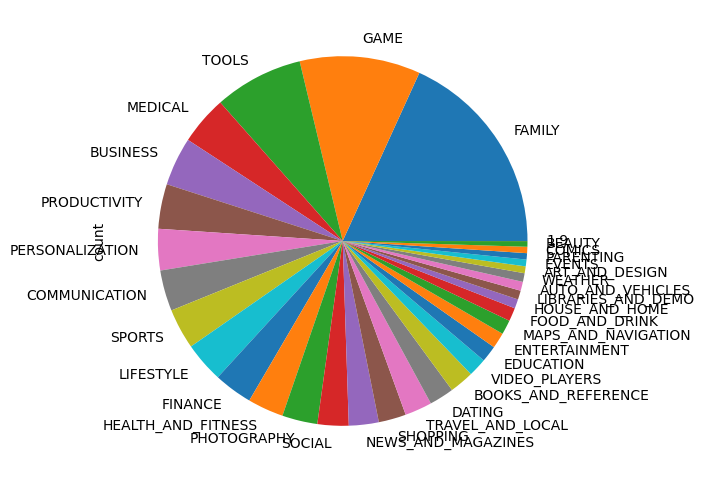

In [1151]:
plot = categories.plot.pie(y='Category', figsize=(11, 6))

In [1152]:
df['Installs'].value_counts()

Installs
1.000000e+06    1579
1.000000e+07    1252
1.000000e+05    1169
1.000000e+04    1054
1.000000e+03     907
5.000000e+06     752
1.000000e+02     719
5.000000e+05     539
5.000000e+04     479
5.000000e+03     477
1.000000e+08     409
1.000000e+01     386
5.000000e+02     330
5.000000e+07     289
5.000000e+01     205
5.000000e+00      82
5.000000e+08      72
1.000000e+00      67
1.000000e+09      58
0.000000e+00      15
Name: count, dtype: int64

In [1153]:
df['Type'].value_counts()

Type
Free    10039
Paid      800
0           1
Name: count, dtype: int64

FIX SHIFTED ROW

In [1154]:
# It seems that in a certain row the data is shifted. Let's find out which row it is

bad_row_index=df.index[df['Category'] == '1.9'].tolist()[0]

# This row (10472) has no category and the other columns are shifted to the left...
# It also has no 'Genre'
# Should we add it to the category 'PHOTOGRAPHY'?
# When the category is 'PHOTOGRAPHY', is the genre always 'Photography'?

In [1155]:
# When the category is 'PHOTOGRAPHY', is the genre always 'Photography'?

df_photography=df.loc[df['Category'] == 'PHOTOGRAPHY', ['Category', 'Genres']]
df_photography.loc[df_photography['Genres'] != 'Photography']

# Yes! So we could replace category with 'PHOTOGRAPHY' and  'Genres' with 'Photography'

,Category,Genres


In [1156]:
row_to_shift=df.iloc[bad_row_index]
row_to_shift

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                         3000000.0
Size                                               1000.0
Installs                                              NaN
Type                                                    0
Price                                                 0.0
Content Rating                                        NaN
Genres                                          11-Feb-18
Last Updated                                          NaT
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [1157]:
df.iloc[bad_row_index, 1:] = row_to_shift.shift(periods=1)[1:]
df.iloc[bad_row_index]

App               Life Made WI-Fi Touchscreen Photo Frame
Category          Life Made WI-Fi Touchscreen Photo Frame
Rating                                                1.9
Reviews                                              19.0
Size                                            3000000.0
Installs                                           1000.0
Type                                                  NaN
Price                                                   0
Content Rating                                        0.0
Genres                                                NaN
Last Updated                          2018-02-11 00:00:00
Current Ver                                           NaT
Android Ver                                    4.0 and up
Name: 10472, dtype: object

In [1158]:
df.loc[bad_row_index,'Category'] = 'PHOTOGRAPHY'
df.loc[bad_row_index,'Genres'] = 'Photography'
df.iloc[bad_row_index]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                      PHOTOGRAPHY
Rating                                                1.9
Reviews                                              19.0
Size                                            3000000.0
Installs                                           1000.0
Type                                                  NaN
Price                                                   0
Content Rating                                        0.0
Genres                                        Photography
Last Updated                          2018-02-11 00:00:00
Current Ver                                           NaT
Android Ver                                    4.0 and up
Name: 10472, dtype: object